In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

## *Text Preprocessing*

In [5]:
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


### Normalizing Case Folding 

In [7]:
df['Review'] = df['Review'].str.lower()

### Punctuations

In [8]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)

### Numbers

In [9]:
df['Review'] = df['Review'].str.replace('\d', '', regex=True)

### Stopwords

In [10]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in stop_words))

### Rare words

In [12]:
rares = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in rares))

### Lemmatization

In [13]:
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in str(x).split()]))

df['Review'].head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
5                                 look different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtain would thinner ...
8    much whiter thought would wasnt really expecti...
9    curtain picture show rd set ambesonne curtain ...
Name: Review, dtype: object

## *Text Vizualization*

### Barplot

In [15]:
tf = df['Review'].apply(lambda x : pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf.columns = ['words', 'tf']

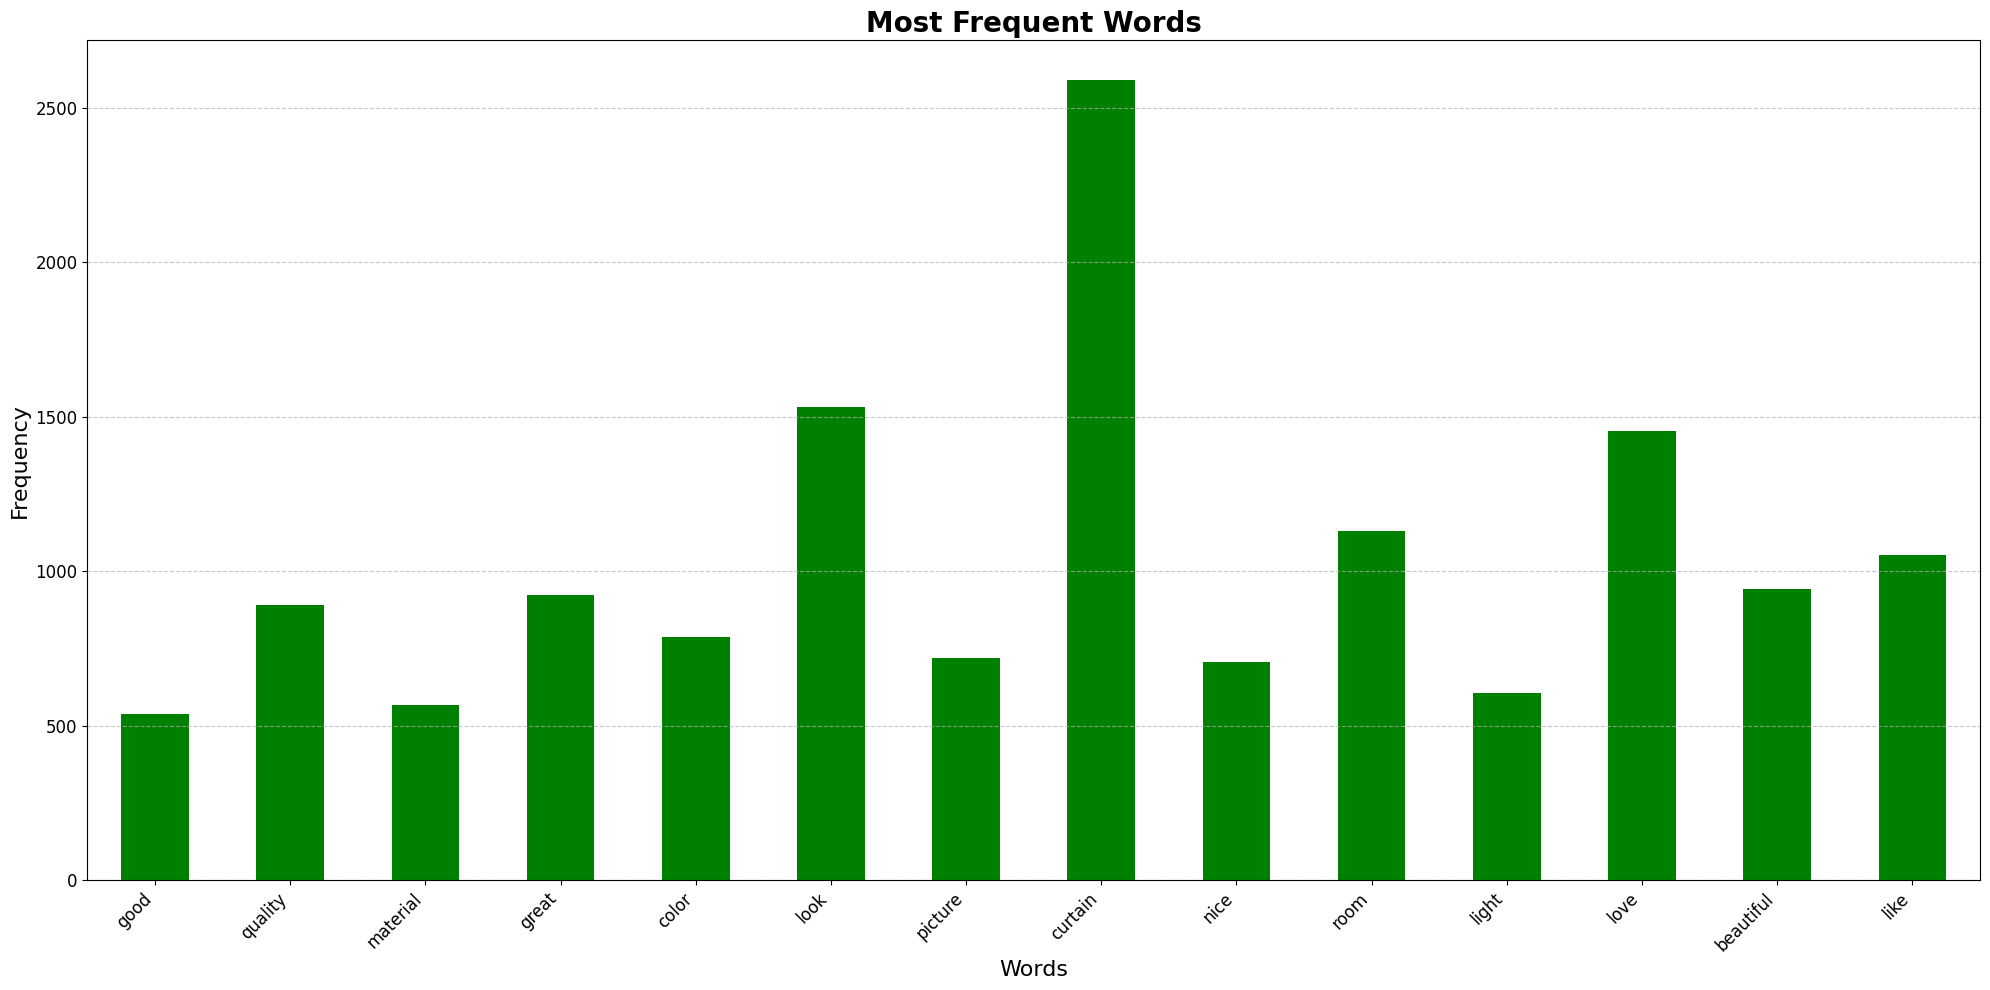

In [18]:
ax = tf[tf['tf'] > 500].plot.bar(
    x='words',
    y='tf',
    figsize=(20, 10),
    legend=False,
    color='green'
)

plt.title("Most Frequent Words", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

### Wordcloud

In [19]:
text = " ".join(i for i in df.Review)

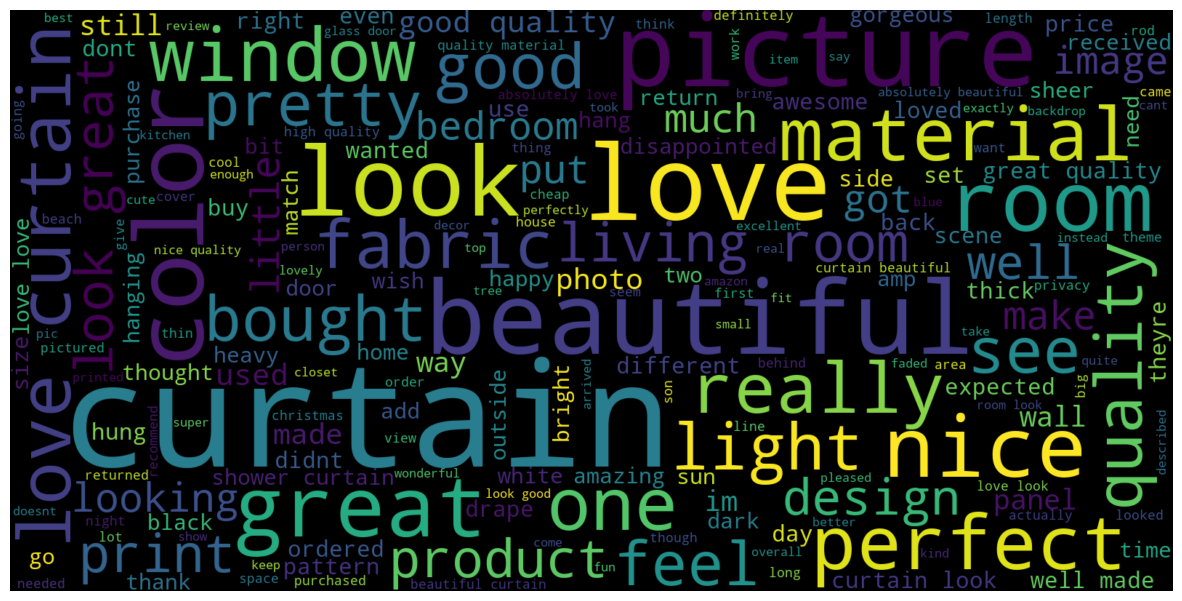

In [22]:
wordcloud = WordCloud(width=1600, 
                      height=800, 
                      random_state=21, 
                      max_font_size=200).generate(text)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## *Sentiment Analysis*

In [30]:
df['Review'].tail()

5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, dtype: object

In [31]:
sia = SentimentIntensityAnalyzer()
df['sentiments'] = df['Review'].apply(lambda x: "pos " if sia.polarity_scores(x)['compound'] > 0 else "neg")

In [32]:
df.groupby('sentiments')['Star'].mean()

sentiments
neg    3.40
pos    4.58
Name: Star, dtype: float64

## *Modelling*

In [33]:
train_x, test_x, train_y, test_y = train_test_split(df['Review'], 
                                                    df['sentiments'], 
                                                    test_size=0.20, 
                                                    random_state=42) 

In [34]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
train_x_tf_idf = tf_idf_word_vectorizer.transform(train_x)
test_x_tf_idf = tf_idf_word_vectorizer.transform(test_x)

In [44]:
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(train_x_tf_idf, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [45]:
y_pred = log_model.predict(test_x_tf_idf)

In [46]:
print(classification_report(test_y, y_pred))

score = cross_val_score(log_model, train_x_tf_idf, train_y, cv=5).mean()
          
print(f"Cross validated average accuracy : {score:.2%}")

              precision    recall  f1-score   support

         neg       0.63      0.91      0.75       180
        pos        0.98      0.90      0.94       943

    accuracy                           0.90      1123
   macro avg       0.81      0.91      0.84      1123
weighted avg       0.93      0.90      0.91      1123

Cross validated average accuracy : 88.93%


In [48]:
random_review = pd.Series(df['Review']).sample(1).values
random_review_tfidf = tf_idf_word_vectorizer.transform(random_review)
predicted_sentiment = log_model.predict(random_review_tfidf)
print(f"Random Review: {random_review[0]}")
print(f"Predicted Sentiment: {predicted_sentiment[0]}")

Random Review: quality curtain especially price exactly pictured pretty shipment next day happy purchase thank
Predicted Sentiment: pos 


In [57]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(train_x_tf_idf, train_y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [58]:
y_pred = rf_model.predict(test_x_tf_idf)

In [59]:
print(classification_report(test_y, y_pred))

score = cross_val_score(rf_model, train_x_tf_idf, train_y, cv=5).mean()

print(f"Cross validated average accuracy : {score:.2%}")

              precision    recall  f1-score   support

         neg       0.87      0.66      0.75       180
        pos        0.94      0.98      0.96       943

    accuracy                           0.93      1123
   macro avg       0.90      0.82      0.85      1123
weighted avg       0.93      0.93      0.93      1123

Cross validated average accuracy : 91.73%
